# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


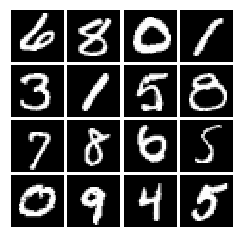

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, alpha*x)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform(maxval=1, minval=-1, shape=[batch_size, dim])


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc2, units=1)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=fc2, units=784, activation=tf.nn.tanh)
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    
    real_img_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real))
    fake_img_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake))
    
    D_loss = tf.reduce_mean(real_img_loss + fake_img_loss)
    
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake))
    G_loss = tf.reduce_mean(gen_loss)
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

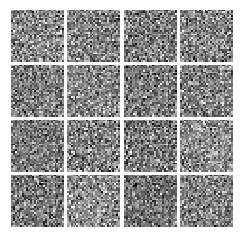


Iter: 0, D: 1.209, G:0.7436
Iter: 50, D: 2.465, G:0.4592
Iter: 100, D: 2.01, G:1.26
Iter: 150, D: 1.534, G:1.107
Iter: 200, D: 1.122, G:1.946


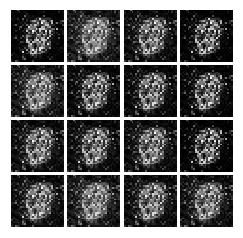


Iter: 250, D: 1.415, G:0.7052
Iter: 300, D: 1.929, G:1.175
Iter: 350, D: 0.942, G:1.868
Iter: 400, D: 0.6912, G:3.033
Iter: 450, D: 0.9929, G:1.607


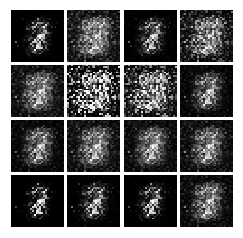


Iter: 500, D: 2.349, G:0.4254
Iter: 550, D: 0.8588, G:1.572
Iter: 600, D: 1.283, G:1.159
Iter: 650, D: 1.184, G:1.091
Iter: 700, D: 1.047, G:1.308


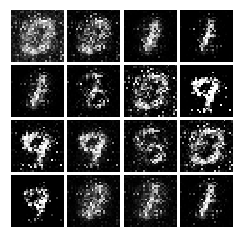


Iter: 750, D: 1.144, G:1.448
Iter: 800, D: 1.275, G:1.48
Iter: 850, D: 1.295, G:0.97
Iter: 900, D: 0.9728, G:0.9342
Iter: 950, D: 1.532, G:0.4628


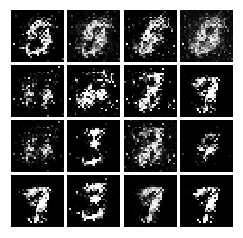


Iter: 1000, D: 1.176, G:1.293
Iter: 1050, D: 1.376, G:1.045
Iter: 1100, D: 1.167, G:1.116
Iter: 1150, D: 1.284, G:1.414
Iter: 1200, D: 1.276, G:2.132


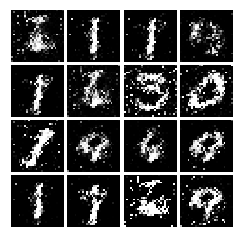


Iter: 1250, D: 1.666, G:0.5701
Iter: 1300, D: 1.334, G:1.284
Iter: 1350, D: 1.262, G:1.126
Iter: 1400, D: 1.209, G:0.8786
Iter: 1450, D: 1.119, G:0.9704


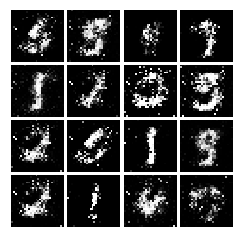


Iter: 1500, D: 1.184, G:0.9429
Iter: 1550, D: 1.19, G:1.016
Iter: 1600, D: 1.313, G:1.064
Iter: 1650, D: 1.198, G:1.283
Iter: 1700, D: 1.162, G:0.9461


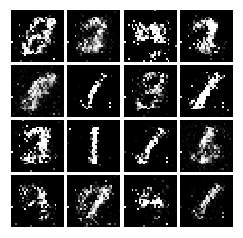


Iter: 1750, D: 1.277, G:1.087
Iter: 1800, D: 1.28, G:0.663
Iter: 1850, D: 1.293, G:0.938
Iter: 1900, D: 1.245, G:0.9005
Iter: 1950, D: 1.365, G:0.717


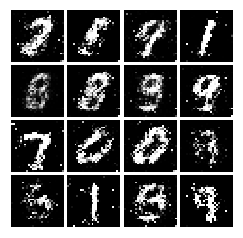


Iter: 2000, D: 1.242, G:1.142
Iter: 2050, D: 1.29, G:0.9648
Iter: 2100, D: 1.297, G:0.9532
Iter: 2150, D: 1.34, G:1.023
Iter: 2200, D: 1.374, G:0.8912


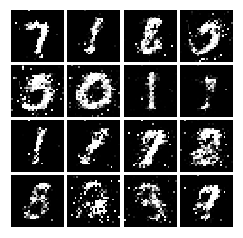


Iter: 2250, D: 1.363, G:0.8844
Iter: 2300, D: 1.405, G:0.7673
Iter: 2350, D: 1.288, G:0.7508
Iter: 2400, D: 1.314, G:0.8507
Iter: 2450, D: 1.395, G:0.7977


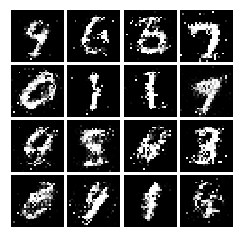


Iter: 2500, D: 1.344, G:0.8858
Iter: 2550, D: 1.291, G:0.8564
Iter: 2600, D: 1.263, G:0.7589
Iter: 2650, D: 1.334, G:0.8901
Iter: 2700, D: 1.339, G:0.8035


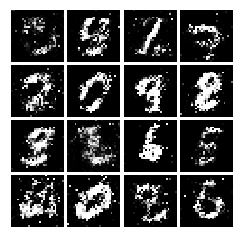


Iter: 2750, D: 1.273, G:0.8265
Iter: 2800, D: 1.403, G:0.8684
Iter: 2850, D: 1.344, G:0.7697
Iter: 2900, D: 1.342, G:0.7526
Iter: 2950, D: 1.319, G:0.7722


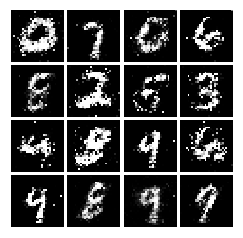


Iter: 3000, D: 1.377, G:0.7932
Iter: 3050, D: 1.308, G:0.8365
Iter: 3100, D: 1.294, G:0.8104
Iter: 3150, D: 1.301, G:0.9168
Iter: 3200, D: 1.291, G:0.8193


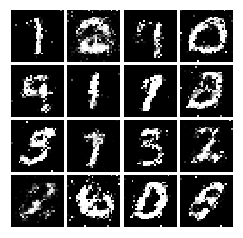


Iter: 3250, D: 1.35, G:0.8412
Iter: 3300, D: 1.357, G:0.7934
Iter: 3350, D: 1.343, G:0.8292
Iter: 3400, D: 1.33, G:0.8325
Iter: 3450, D: 1.383, G:0.8211


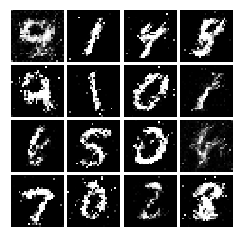


Iter: 3500, D: 1.387, G:0.8169
Iter: 3550, D: 1.271, G:0.8318
Iter: 3600, D: 1.305, G:0.8076
Iter: 3650, D: 1.305, G:0.852
Iter: 3700, D: 1.373, G:0.9116


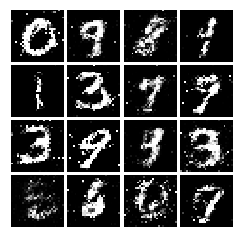


Iter: 3750, D: 1.268, G:0.8233
Iter: 3800, D: 1.344, G:0.8303
Iter: 3850, D: 1.323, G:0.828
Iter: 3900, D: 1.314, G:0.8704
Iter: 3950, D: 1.322, G:0.8546


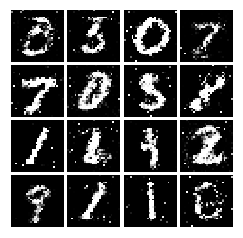


Iter: 4000, D: 1.308, G:0.8762
Iter: 4050, D: 1.281, G:0.7733
Iter: 4100, D: 1.321, G:0.7514
Iter: 4150, D: 1.283, G:0.8437
Iter: 4200, D: 1.335, G:0.791


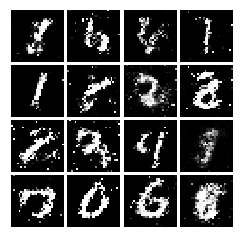


Iter: 4250, D: 1.314, G:0.7971
Final images


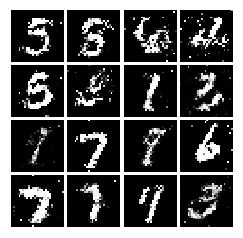

In [30]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [16]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    correct_labels = tf.ones_like(score_real)
    
    real_loss = tf.reduce_mean((score_real - correct_labels)**2)
    fake_loss = tf.reduce_mean(score_fake**2)
    D_loss = 0.5 * (fake_loss + real_loss)
    G_loss = 0.5 * (tf.reduce_mean((score_fake - tf.ones_like(score_fake))**2))
    
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [17]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [18]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

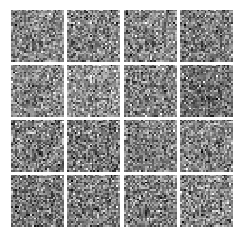


Iter: 0, D: 1.206, G:0.3751
Iter: 50, D: 0.1397, G:1.458
Iter: 100, D: 0.04072, G:0.7746
Iter: 150, D: 0.123, G:0.2553
Iter: 200, D: 0.1558, G:0.1456


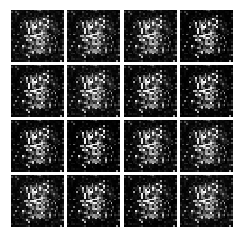


Iter: 250, D: 0.155, G:0.5818
Iter: 300, D: 0.07018, G:0.5645
Iter: 350, D: 0.06443, G:0.5076
Iter: 400, D: 0.173, G:0.4205
Iter: 450, D: 0.1323, G:0.4129


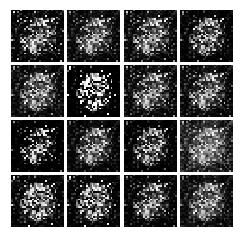


Iter: 500, D: 0.1182, G:0.3461
Iter: 550, D: 0.1905, G:0.2818
Iter: 600, D: 0.1948, G:0.2802
Iter: 650, D: 0.1163, G:0.4541
Iter: 700, D: 0.6684, G:0.2861


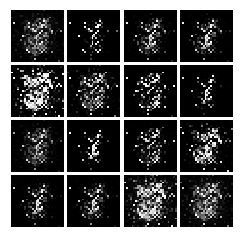


Iter: 750, D: 0.1022, G:0.7753
Iter: 800, D: 0.3298, G:0.09952
Iter: 850, D: 0.1498, G:0.317
Iter: 900, D: 0.1236, G:0.3911
Iter: 950, D: 0.1211, G:0.3597


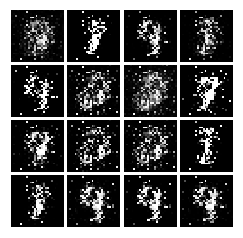


Iter: 1000, D: 0.1778, G:0.3463
Iter: 1050, D: 0.09826, G:0.4552
Iter: 1100, D: 0.2043, G:0.3131
Iter: 1150, D: 0.1851, G:0.2806
Iter: 1200, D: 0.1415, G:0.3277


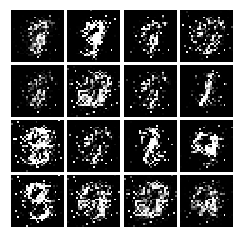


Iter: 1250, D: 0.1618, G:0.3561
Iter: 1300, D: 0.2006, G:0.2661
Iter: 1350, D: 0.168, G:0.2465
Iter: 1400, D: 0.1799, G:0.2677
Iter: 1450, D: 0.1841, G:0.2652


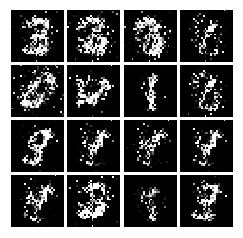


Iter: 1500, D: 0.1458, G:0.2876
Iter: 1550, D: 0.2831, G:0.2765
Iter: 1600, D: 0.1936, G:0.2477
Iter: 1650, D: 0.2001, G:0.2358
Iter: 1700, D: 0.1982, G:0.1954


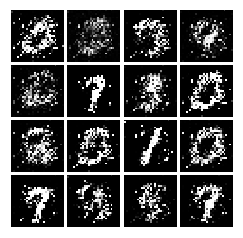


Iter: 1750, D: 0.2336, G:0.2219
Iter: 1800, D: 0.2156, G:0.1274
Iter: 1850, D: 0.1987, G:0.2317
Iter: 1900, D: 0.2131, G:0.1797
Iter: 1950, D: 0.1849, G:0.2009


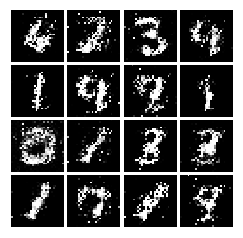


Iter: 2000, D: 0.1784, G:0.2504
Iter: 2050, D: 0.2273, G:0.1922
Iter: 2100, D: 0.4022, G:0.217
Iter: 2150, D: 0.2589, G:0.1447
Iter: 2200, D: 0.2345, G:0.1942


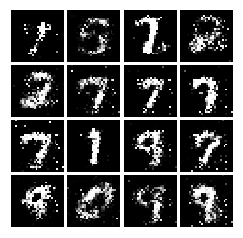


Iter: 2250, D: 0.2098, G:0.2058
Iter: 2300, D: 0.23, G:0.1655
Iter: 2350, D: 0.2205, G:0.159
Iter: 2400, D: 0.2098, G:0.1655
Iter: 2450, D: 0.2555, G:0.1931


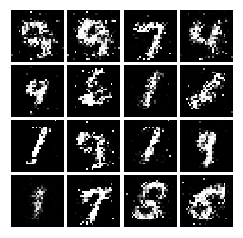


Iter: 2500, D: 0.235, G:0.1607
Iter: 2550, D: 0.2163, G:0.1861
Iter: 2600, D: 0.2035, G:0.2098
Iter: 2650, D: 0.2463, G:0.1904
Iter: 2700, D: 0.2281, G:0.1802


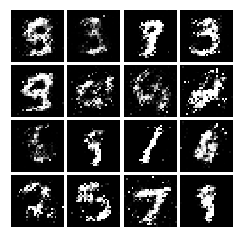


Iter: 2750, D: 0.2237, G:0.1782
Iter: 2800, D: 0.2432, G:0.2341
Iter: 2850, D: 0.2379, G:0.1597
Iter: 2900, D: 0.2195, G:0.1541
Iter: 2950, D: 0.2081, G:0.1998


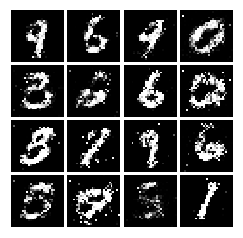


Iter: 3000, D: 0.2294, G:0.2035
Iter: 3050, D: 0.2122, G:0.1801
Iter: 3100, D: 0.2074, G:0.1846
Iter: 3150, D: 0.2016, G:0.1855
Iter: 3200, D: 0.2231, G:0.1875


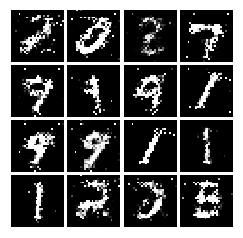


Iter: 3250, D: 0.2243, G:0.1861
Iter: 3300, D: 0.2423, G:0.1654
Iter: 3350, D: 0.2168, G:0.2018
Iter: 3400, D: 0.2225, G:0.1766
Iter: 3450, D: 0.2364, G:0.1764


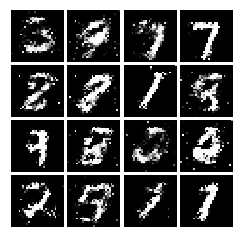


Iter: 3500, D: 0.2355, G:0.1861
Iter: 3550, D: 0.225, G:0.1862
Iter: 3600, D: 0.2265, G:0.1476
Iter: 3650, D: 0.2203, G:0.1499
Iter: 3700, D: 0.2235, G:0.1533


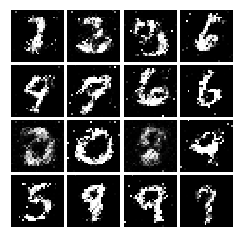


Iter: 3750, D: 0.2311, G:0.175
Iter: 3800, D: 0.2298, G:0.1503
Iter: 3850, D: 0.2511, G:0.1905
Iter: 3900, D: 0.2311, G:0.1726
Iter: 3950, D: 0.2389, G:0.1566


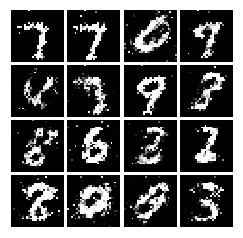


Iter: 4000, D: 0.2163, G:0.1678
Iter: 4050, D: 0.2294, G:0.1737
Iter: 4100, D: 0.2356, G:0.1801
Iter: 4150, D: 0.2302, G:0.1757
Iter: 4200, D: 0.2059, G:0.1615


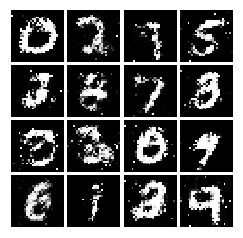


Iter: 4250, D: 0.2237, G:0.1629
Final images


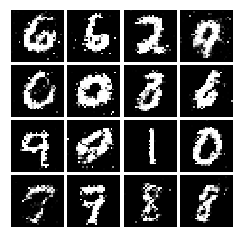

In [19]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [21]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x, (-1, 28, 28, 1))
        
        c1 = tf.layers.conv2d(x, filters=32, kernel_size=(5, 5), strides = (1, 1))
        r1 = leaky_relu(c1, alpha=0.01)
        p1 = tf.layers.max_pooling2d(r1, pool_size = [2, 2], strides=2)
        
        c2 = tf.layers.conv2d(p1, filters=64, kernel_size=(5, 5), strides = (1, 1))
        r2 = leaky_relu(c2, alpha=0.01)
        p2 = tf.layers.max_pooling2d(r2, pool_size=[2, 2], strides=2)
        
        n1 = tf.reshape(p2, (-1, 1024))
        n2 = tf.layers.dense(n1, 1024)
        r3 = leaky_relu(n2, alpha=0.01)
        
        logits = tf.layers.dense(r3, 1)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [25]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        n, d = z.get_shape().as_list()
        n1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        b1 = tf.layers.batch_normalization(n1, training=True)
        
        n2 = tf.layers.dense(b1, 7*7*128, activation=tf.nn.relu)
        b2 = tf.layers.batch_normalization(n2, training=True)
        
        img1 = tf.reshape(b2, [n, 7, 7, 128])
        c1 = tf.layers.conv2d_transpose(img1, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        b3 = tf.layers.batch_normalization(c1, training=True)
        
        c2 = tf.layers.conv2d_transpose(b3, filters=1, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(c2, [n, 784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [26]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

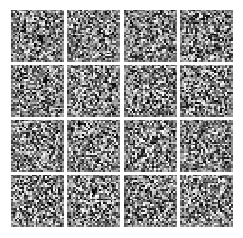


Iter: 0, D: 1.429, G:0.6562
Iter: 50, D: 5.202, G:0.04962
Iter: 100, D: 0.9262, G:1.011
Iter: 150, D: 0.8454, G:1.28
Iter: 200, D: 1.396, G:1.274


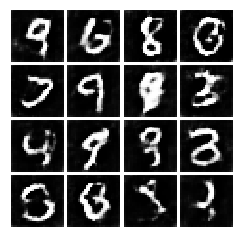


Iter: 250, D: 1.098, G:0.7795
Iter: 300, D: 1.021, G:1.211
Iter: 350, D: 1.058, G:0.9381
Iter: 400, D: 1.167, G:1.094
Iter: 450, D: 1.178, G:1.13


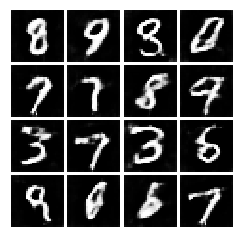


Iter: 500, D: 1.095, G:0.983
Iter: 550, D: 1.127, G:1.088
Iter: 600, D: 1.067, G:1.141
Iter: 650, D: 1.137, G:1.193
Iter: 700, D: 1.0, G:1.068


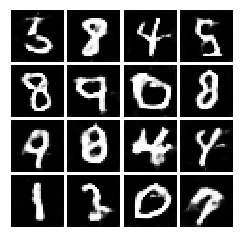


Iter: 750, D: 1.077, G:1.049
Iter: 800, D: 1.115, G:1.148
Iter: 850, D: 1.149, G:0.858
Iter: 900, D: 1.146, G:0.7819
Iter: 950, D: 1.062, G:1.138


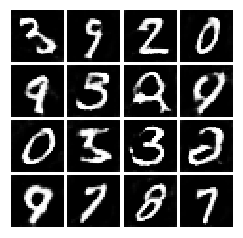


Iter: 1000, D: 1.148, G:1.113
Iter: 1050, D: 1.182, G:1.067
Iter: 1100, D: 1.171, G:0.9736
Iter: 1150, D: 1.033, G:1.082
Iter: 1200, D: 1.227, G:1.098


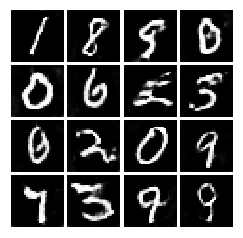


Iter: 1250, D: 1.164, G:1.065
Iter: 1300, D: 1.042, G:1.049
Iter: 1350, D: 1.019, G:1.023
Iter: 1400, D: 1.145, G:1.16
Iter: 1450, D: 1.071, G:0.8718


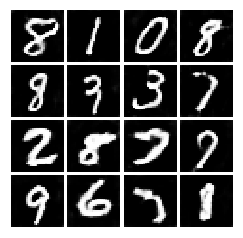


Iter: 1500, D: 1.095, G:1.003
Iter: 1550, D: 1.303, G:2.448
Iter: 1600, D: 1.066, G:0.8964
Iter: 1650, D: 1.039, G:0.9898
Iter: 1700, D: 1.326, G:2.032


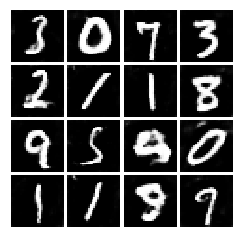


Iter: 1750, D: 1.055, G:1.313
Iter: 1800, D: 1.237, G:1.369
Iter: 1850, D: 1.215, G:0.8245
Iter: 1900, D: 1.023, G:1.313
Iter: 1950, D: 1.186, G:1.728


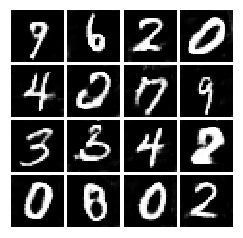


Iter: 2000, D: 1.004, G:1.075
Iter: 2050, D: 0.9951, G:1.008
Iter: 2100, D: 1.046, G:1.251
Final images


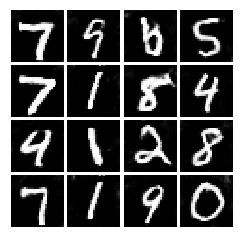

In [27]:
with get_session() as sess: 
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)